In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torcheval.metrics.functional import binary_f1_score

import pandas as pd
from tqdm import trange
from plotly import graph_objects as go
import tiktoken

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
data_df = pd.read_csv("hf://datasets/aengusbl/custom_AT-T_data/better_data.csv")
data_df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,labels,docs
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Without pre-processing

In [30]:
tokeniser = tiktoken.get_encoding("cl100k_base")

tokenised_df = data_df.copy()
tokenised_df["tokenised"] = tokenised_df["docs"].apply(lambda doc: tokeniser.encode(doc))
tokenised_df["tokenised_len"] = tokenised_df["tokenised"].apply(lambda doc: len(doc))
tokenised_df.head()

,labels,docs,tokenised,tokenised_len
0,ham,"Go until jurong point, crazy.. Available only ...","[11087, 3156, 16422, 647, 1486, 11, 14599, 497...",27
1,ham,Ok lar... Joking wif u oni...,"[11839, 45555, 1131, 622, 10979, 289, 333, 577...",11
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[11180, 4441, 304, 220, 17, 264, 74860, 398, 1...",50
3,ham,U dun say so early hor... U c already then say...,"[52, 50116, 2019, 779, 4216, 4917, 1131, 549, ...",13
4,ham,"Nah I don't think he goes to usf, he lives aro...","[45, 1494, 358, 1541, 956, 1781, 568, 5900, 31...",17


In [31]:
split_tokenised_dict = dict(labels = [], tokenised = [], tokenised_len = [])
split_threshold = 50 # arbitrary

for row_num in trange(len(tokenised_df)):
    row = tokenised_df.loc[row_num,:]
    if  row.tokenised_len < split_threshold:
        num_parts = 1
    elif row.tokenised_len < (split_threshold * 3):
        num_parts = 2
    else:
        num_parts = 3

    part_len = row.tokenised_len // num_parts
    for part in range(num_parts):
        split_tokenised_dict["labels"].append(row.labels)
        new_tokenised_doc = row.tokenised[(part*part_len):((part+1)*part_len)] # This works because you can give a slice out of range, and because `part*part_len == 0` at the start of range()
        split_tokenised_dict["tokenised"].append(new_tokenised_doc)
        split_tokenised_dict["tokenised_len"].append(len(new_tokenised_doc))

split_tokenised_df = pd.DataFrame(split_tokenised_dict)
split_tokenised_df.head()

100%|██████████| 5173/5173 [00:00<00:00, 5920.14it/s]


,labels,tokenised,tokenised_len
0,ham,"[11087, 3156, 16422, 647, 1486, 11, 14599, 497...",27
1,ham,"[11839, 45555, 1131, 622, 10979, 289, 333, 577...",11
2,spam,"[11180, 4441, 304, 220, 17, 264, 74860, 398, 1...",25
3,spam,"[15358, 311, 220, 25665, 1691, 311, 5371, 4441...",25
4,ham,"[52, 50116, 2019, 779, 4216, 4917, 1131, 549, ...",13


In [32]:
def normalise_sequence_len(sequences, max_length=50):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

train_tokens = normalise_sequence_len(split_tokenised_df.tokenised) # no third "test" set

In [33]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

spam_dataset = SpamDataset(train_tokens, split_tokenised_df.labels.map(dict(spam=1, ham=0)))

train_size = int(0.8 * len(spam_dataset))
val_size = len(spam_dataset) - train_size
train_dataset, val_dataset = random_split(spam_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [34]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_dim,
                                      padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        logits = self.fc(pooled)
        return torch.sigmoid(logits)

vocab_size = tokeniser.n_vocab

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=int(vocab_size**0.25), # see below why
                      num_class=1)

[Why `vocab_size**0.25`](https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/#:~:text=the%20embedding%20vector%20dimension%20should%20be%20the%204th%20root%20of%20the%20number%20of%20categories). I am also confident in this choice because the result (~17) is very close to the value in the lesson (16).

In [35]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct_preds = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            correct_preds += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct_preds / len(train_loader.dataset)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct_preds = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct_preds += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct_preds / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=50)

Epoch [1/50], Loss: 0.6417, Acc: 0.8342, Val Loss: 0.6070, Val Acc: 0.8421
Epoch [2/50], Loss: 0.5663, Acc: 0.8524, Val Loss: 0.5243, Val Acc: 0.8484
Epoch [3/50], Loss: 0.4731, Acc: 0.8691, Val Loss: 0.4283, Val Acc: 0.8718
Epoch [4/50], Loss: 0.3780, Acc: 0.9066, Val Loss: 0.3444, Val Acc: 0.9152
Epoch [5/50], Loss: 0.2997, Acc: 0.9404, Val Loss: 0.2796, Val Acc: 0.9386
Epoch [6/50], Loss: 0.2406, Acc: 0.9569, Val Loss: 0.2314, Val Acc: 0.9477
Epoch [7/50], Loss: 0.1973, Acc: 0.9675, Val Loss: 0.1964, Val Acc: 0.9558
Epoch [8/50], Loss: 0.1653, Acc: 0.9734, Val Loss: 0.1707, Val Acc: 0.9657
Epoch [9/50], Loss: 0.1412, Acc: 0.9772, Val Loss: 0.1513, Val Acc: 0.9711
Epoch [10/50], Loss: 0.1237, Acc: 0.9806, Val Loss: 0.1364, Val Acc: 0.9729
Epoch [11/50], Loss: 0.1088, Acc: 0.9833, Val Loss: 0.1248, Val Acc: 0.9729
Epoch [12/50], Loss: 0.0974, Acc: 0.9844, Val Loss: 0.1153, Val Acc: 0.9720
Epoch [13/50], Loss: 0.0879, Acc: 0.9867, Val Loss: 0.1075, Val Acc: 0.9747
Epoch [14/50], Loss: 

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
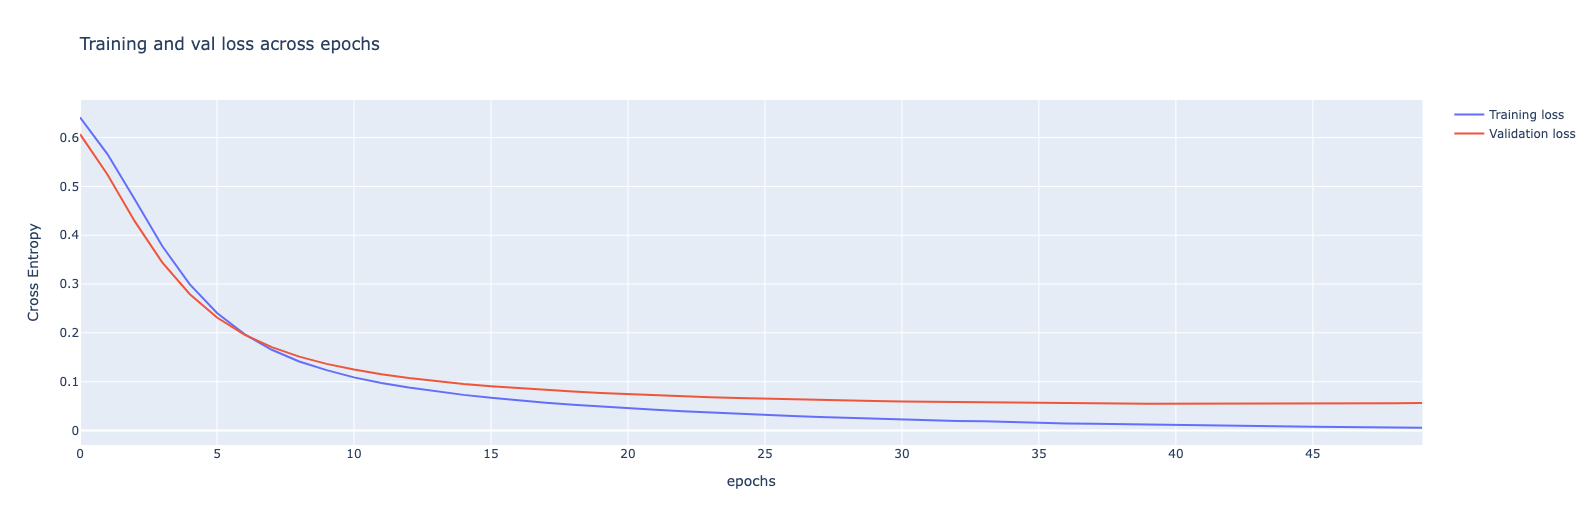

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
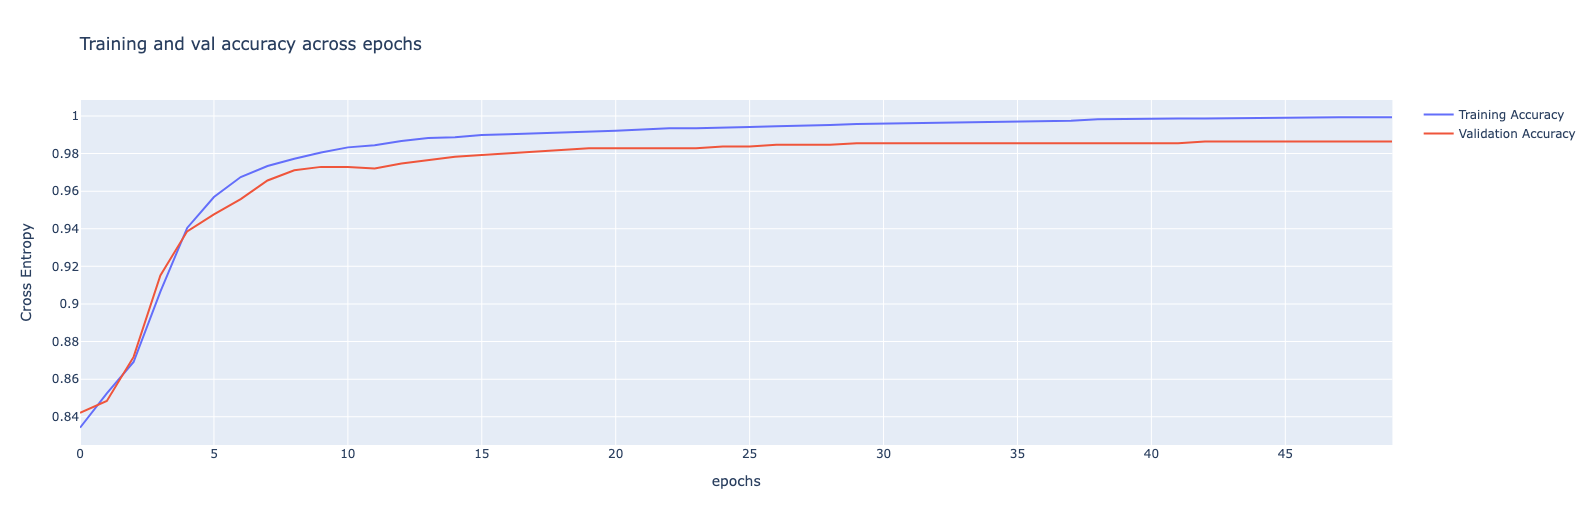

### With pre-processing

In [6]:
#!pip install spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 24.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_md

nlp = en_core_web_md.load()

In [10]:
df = data_df.copy()
df["clean_docs"] = df["docs"].str.replace(r"[^a-zA-Z0-9']+", " ", regex=True)\
                             .apply(lambda desc: nlp(desc.lower()))\
                             .apply(lambda doc: [token.lemma_ for token in doc if token.text not in STOP_WORDS])\
                             .apply(lambda ls: " ".join(ls))

In [11]:
tokeniser = tiktoken.get_encoding("cl100k_base")

tokenised_df = df.copy()
tokenised_df["tokenised"] = tokenised_df["docs"].apply(lambda doc: tokeniser.encode(doc))
tokenised_df["tokenised_len"] = tokenised_df["tokenised"].apply(lambda doc: len(doc))
tokenised_df.head()

,labels,docs,clean_docs,tokenised,tokenised_len
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[11087, 3156, 16422, 647, 1486, 11, 14599, 497...",27
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[11839, 45555, 1131, 622, 10979, 289, 333, 577...",11
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11180, 4441, 304, 220, 17, 264, 74860, 398, 1...",50
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[52, 50116, 2019, 779, 4216, 4917, 1131, 549, ...",13
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live,"[45, 1494, 358, 1541, 956, 1781, 568, 5900, 31...",17


In [12]:
split_tokenised_dict = dict(labels = [], tokenised = [], tokenised_len = [])
split_threshold = 50 # arbitrary

for row_num in trange(len(tokenised_df)):
    row = tokenised_df.loc[row_num,:]
    if  row.tokenised_len < split_threshold:
        num_parts = 1
    elif row.tokenised_len < (split_threshold * 3):
        num_parts = 2
    else:
        num_parts = 3

    part_len = row.tokenised_len // num_parts
    for part in range(num_parts):
        split_tokenised_dict["labels"].append(row.labels)
        new_tokenised_doc = row.tokenised[(part*part_len):((part+1)*part_len)] # This works because you can give a slice out of range, and because `part*part_len == 0` at the start of range()
        split_tokenised_dict["tokenised"].append(new_tokenised_doc)
        split_tokenised_dict["tokenised_len"].append(len(new_tokenised_doc))

split_tokenised_df = pd.DataFrame(split_tokenised_dict)
split_tokenised_df.head()

100%|██████████| 5173/5173 [00:00<00:00, 11318.63it/s]


,labels,tokenised,tokenised_len
0,ham,"[11087, 3156, 16422, 647, 1486, 11, 14599, 497...",27
1,ham,"[11839, 45555, 1131, 622, 10979, 289, 333, 577...",11
2,spam,"[11180, 4441, 304, 220, 17, 264, 74860, 398, 1...",25
3,spam,"[15358, 311, 220, 25665, 1691, 311, 5371, 4441...",25
4,ham,"[52, 50116, 2019, 779, 4216, 4917, 1131, 549, ...",13


In [13]:
def normalise_sequence_len(sequences, max_length=50):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

train_tokens = normalise_sequence_len(split_tokenised_df.tokenised) # no third "test" set

In [14]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

spam_dataset = SpamDataset(train_tokens, split_tokenised_df.labels.map(dict(spam=1, ham=0)))

train_size = int(0.8 * len(spam_dataset))
val_size = len(spam_dataset) - train_size
train_dataset, val_dataset = random_split(spam_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_dim,
                                      padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        logits = self.fc(pooled)
        return torch.sigmoid(logits)

vocab_size = tokeniser.n_vocab

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=int(vocab_size**0.25), # see below why
                      num_class=1)

[Why `vocab_size**0.25`](https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/#:~:text=the%20embedding%20vector%20dimension%20should%20be%20the%204th%20root%20of%20the%20number%20of%20categories). I am also confident in this choice because the result (~17) is very close to the value in the lesson (16).

In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct_preds = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            correct_preds += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct_preds / len(train_loader.dataset)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct_preds = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct_preds += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct_preds / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=50)

Epoch [1/50], Loss: 0.6303, Acc: 0.8468, Val Loss: 0.5938, Val Acc: 0.8448
Epoch [2/50], Loss: 0.5493, Acc: 0.8497, Val Loss: 0.5059, Val Acc: 0.8475
Epoch [3/50], Loss: 0.4568, Acc: 0.8569, Val Loss: 0.4161, Val Acc: 0.8628
Epoch [4/50], Loss: 0.3694, Acc: 0.8903, Val Loss: 0.3389, Val Acc: 0.9052
Epoch [5/50], Loss: 0.2946, Acc: 0.9292, Val Loss: 0.2778, Val Acc: 0.9431
Epoch [6/50], Loss: 0.2365, Acc: 0.9479, Val Loss: 0.2329, Val Acc: 0.9567
Epoch [7/50], Loss: 0.1928, Acc: 0.9644, Val Loss: 0.2008, Val Acc: 0.9594
Epoch [8/50], Loss: 0.1607, Acc: 0.9738, Val Loss: 0.1782, Val Acc: 0.9612
Epoch [9/50], Loss: 0.1372, Acc: 0.9792, Val Loss: 0.1619, Val Acc: 0.9675
Epoch [10/50], Loss: 0.1188, Acc: 0.9822, Val Loss: 0.1498, Val Acc: 0.9693
Epoch [11/50], Loss: 0.1050, Acc: 0.9835, Val Loss: 0.1406, Val Acc: 0.9693
Epoch [12/50], Loss: 0.0928, Acc: 0.9860, Val Loss: 0.1334, Val Acc: 0.9702
Epoch [13/50], Loss: 0.0843, Acc: 0.9878, Val Loss: 0.1275, Val Acc: 0.9702
Epoch [14/50], Loss: 

In [ ]:
from plotly import graph_objects as go

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
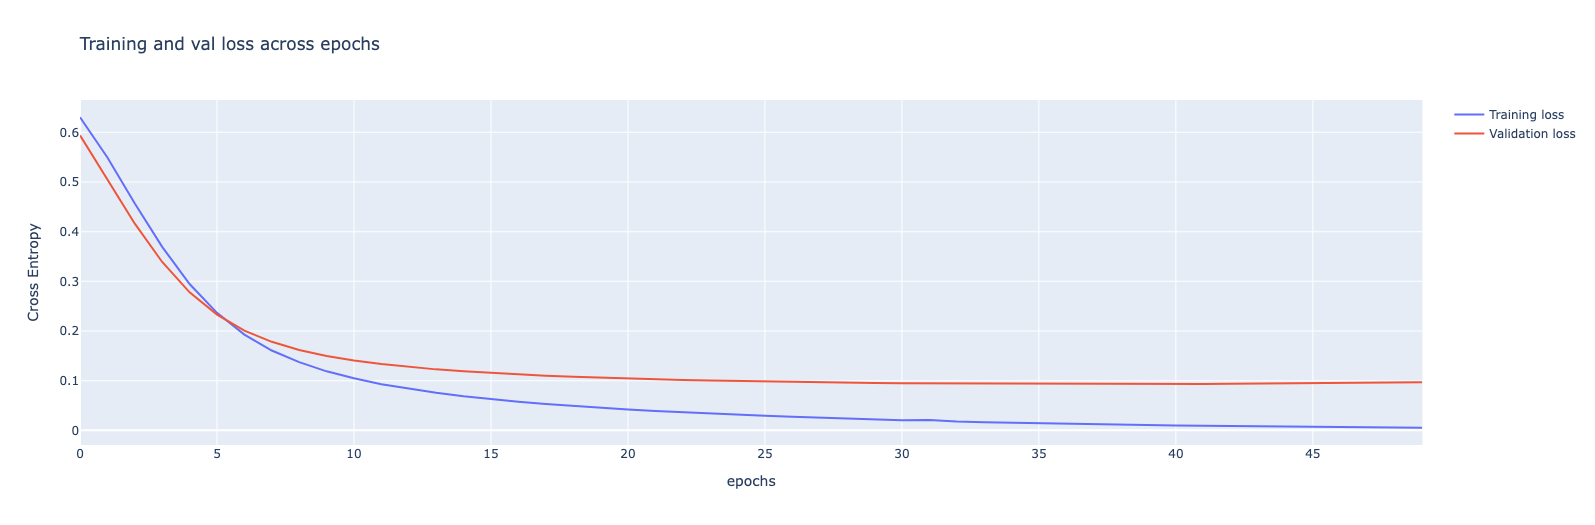

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training Accuracy",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
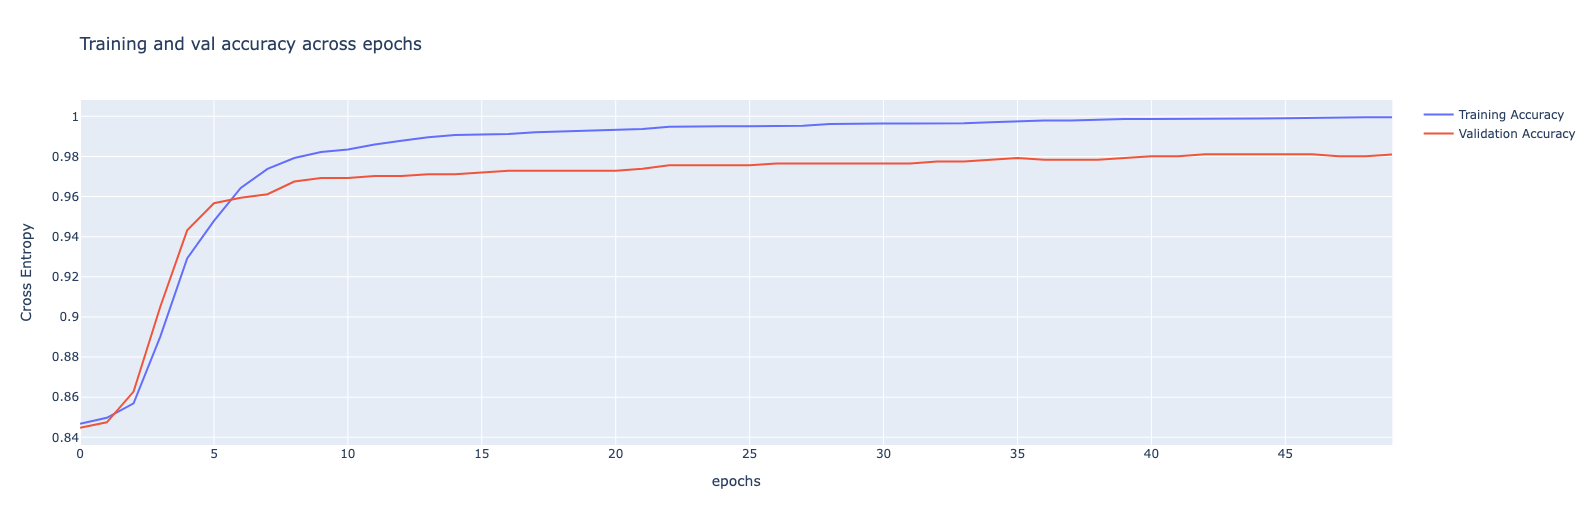

### The performances were very similar, and they were even a little better without spaCy. Let's try an F1 score instead of accuracy since the labels aren't distributed in a balanced way.

In [21]:
tokeniser = tiktoken.get_encoding("cl100k_base")

tokenised_df = data_df.copy()
tokenised_df["tokenised"] = tokenised_df["docs"].apply(lambda doc: tokeniser.encode(doc))
tokenised_df["tokenised_len"] = tokenised_df["tokenised"].apply(lambda doc: len(doc))
tokenised_df.head()

,labels,docs,tokenised,tokenised_len
0,ham,"Go until jurong point, crazy.. Available only ...","[11087, 3156, 16422, 647, 1486, 11, 14599, 497...",27
1,ham,Ok lar... Joking wif u oni...,"[11839, 45555, 1131, 622, 10979, 289, 333, 577...",11
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[11180, 4441, 304, 220, 17, 264, 74860, 398, 1...",50
3,ham,U dun say so early hor... U c already then say...,"[52, 50116, 2019, 779, 4216, 4917, 1131, 549, ...",13
4,ham,"Nah I don't think he goes to usf, he lives aro...","[45, 1494, 358, 1541, 956, 1781, 568, 5900, 31...",17


In [22]:
split_tokenised_dict = dict(labels = [], tokenised = [], tokenised_len = [])
split_threshold = 50 # arbitrary

for row_num in trange(len(tokenised_df)):
    row = tokenised_df.loc[row_num,:]
    if  row.tokenised_len < split_threshold:
        num_parts = 1
    elif row.tokenised_len < (split_threshold * 3):
        num_parts = 2
    else:
        num_parts = 3

    part_len = row.tokenised_len // num_parts
    for part in range(num_parts):
        split_tokenised_dict["labels"].append(row.labels)
        new_tokenised_doc = row.tokenised[(part*part_len):((part+1)*part_len)] # This works because you can give a slice out of range, and because `part*part_len == 0` at the start of range()
        split_tokenised_dict["tokenised"].append(new_tokenised_doc)
        split_tokenised_dict["tokenised_len"].append(len(new_tokenised_doc))

split_tokenised_df = pd.DataFrame(split_tokenised_dict)
split_tokenised_df.head()

100%|██████████| 5173/5173 [00:00<00:00, 5511.24it/s]


,labels,tokenised,tokenised_len
0,ham,"[11087, 3156, 16422, 647, 1486, 11, 14599, 497...",27
1,ham,"[11839, 45555, 1131, 622, 10979, 289, 333, 577...",11
2,spam,"[11180, 4441, 304, 220, 17, 264, 74860, 398, 1...",25
3,spam,"[15358, 311, 220, 25665, 1691, 311, 5371, 4441...",25
4,ham,"[52, 50116, 2019, 779, 4216, 4917, 1131, 549, ...",13


In [23]:
def normalise_sequence_len(sequences, max_length=50):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

train_tokens = normalise_sequence_len(split_tokenised_df.tokenised) # no third "test" set

In [24]:
class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

spam_dataset = SpamDataset(train_tokens, split_tokenised_df.labels.map(dict(spam=1, ham=0)))

train_size = int(0.8 * len(spam_dataset))
val_size = len(spam_dataset) - train_size
train_dataset, val_dataset = random_split(spam_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [25]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embed_dim,
                                      padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        logits = self.fc(pooled)
        return torch.sigmoid(logits)

vocab_size = tokeniser.n_vocab

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=int(vocab_size**0.25), # see below why
                      num_class=1)

[Why `vocab_size**0.25`](https://developers.googleblog.com/en/introducing-tensorflow-feature-columns/#:~:text=the%20embedding%20vector%20dimension%20should%20be%20the%204th%20root%20of%20the%20number%20of%20categories). I am also confident in this choice because the result (~17) is very close to the value in the lesson (16).

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):

    history = {'loss': [], 'val_loss': [], 'f1': [], 'val_f1': []}

    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct_preds = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        all_train_outputs = []
        all_train_labels = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            all_train_outputs.append(outputs)
            all_train_labels.append(labels)

        # Compute average loss and F1 score for training
        train_loss = total_loss / len(train_loader)
        train_f1 = binary_f1_score(torch.cat(all_train_outputs),
                                   torch.cat(all_train_labels),
                                   threshold=0.5)

        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct_preds = 0, 0
        all_val_outputs = []
        all_val_labels = []
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                all_val_outputs.append(outputs)
                all_val_labels.append(labels)

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_f1 = binary_f1_score(torch.cat(all_val_outputs),
                                 torch.cat(all_val_labels),
                                 threshold=0.5)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, F1: {train_f1:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=50)

Epoch [1/50], Loss: 0.2582, F1: 0.6599, Val Loss: 0.2646, Val F1: 0.6165
Epoch [2/50], Loss: 0.2134, F1: 0.7729, Val Loss: 0.2242, Val F1: 0.6996
Epoch [3/50], Loss: 0.1778, F1: 0.8371, Val Loss: 0.1913, Val F1: 0.7708
Epoch [4/50], Loss: 0.1496, F1: 0.8755, Val Loss: 0.1658, Val F1: 0.8339
Epoch [5/50], Loss: 0.1285, F1: 0.8963, Val Loss: 0.1458, Val F1: 0.8709
Epoch [6/50], Loss: 0.1117, F1: 0.9144, Val Loss: 0.1300, Val F1: 0.8876
Epoch [7/50], Loss: 0.0990, F1: 0.9259, Val Loss: 0.1176, Val F1: 0.9006
Epoch [8/50], Loss: 0.0881, F1: 0.9371, Val Loss: 0.1075, Val F1: 0.9226
Epoch [9/50], Loss: 0.0792, F1: 0.9446, Val Loss: 0.0992, Val F1: 0.9288
Epoch [10/50], Loss: 0.0717, F1: 0.9495, Val Loss: 0.0922, Val F1: 0.9348
Epoch [11/50], Loss: 0.0652, F1: 0.9560, Val Loss: 0.0864, Val F1: 0.9379
Epoch [12/50], Loss: 0.0595, F1: 0.9593, Val Loss: 0.0814, Val F1: 0.9379
Epoch [13/50], Loss: 0.0556, F1: 0.9633, Val Loss: 0.0771, Val F1: 0.9408
Epoch [14/50], Loss: 0.0500, F1: 0.9680, Val Lo

In [ ]:
from plotly import graph_objects as go

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
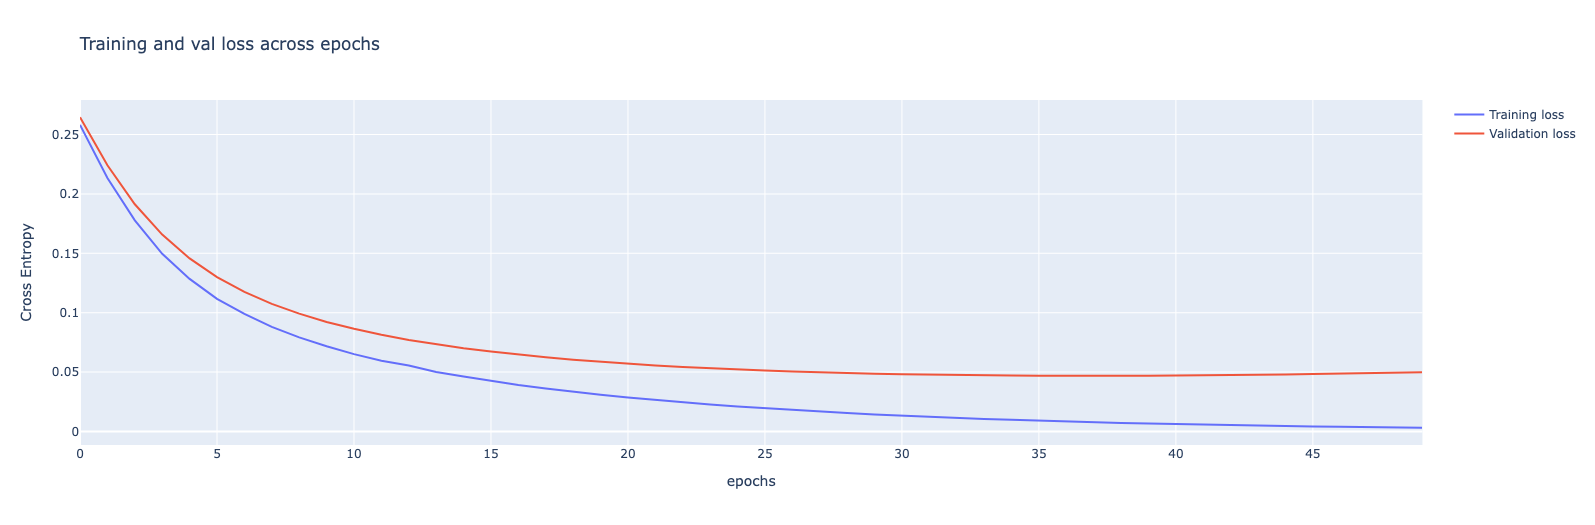

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["f1"],
                          name="Training F1",
                          mode="lines"
                          ),
                      go.Scatter(
                          y=history["val_f1"],
                          name="Validation F1",
                          mode="lines"
                          )
])
fig.update_layout(
    title='Training and val F1 across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

*(This is an image, as the html diagrams made by plotly somehow get broken by downloading the notebook from Colab)*
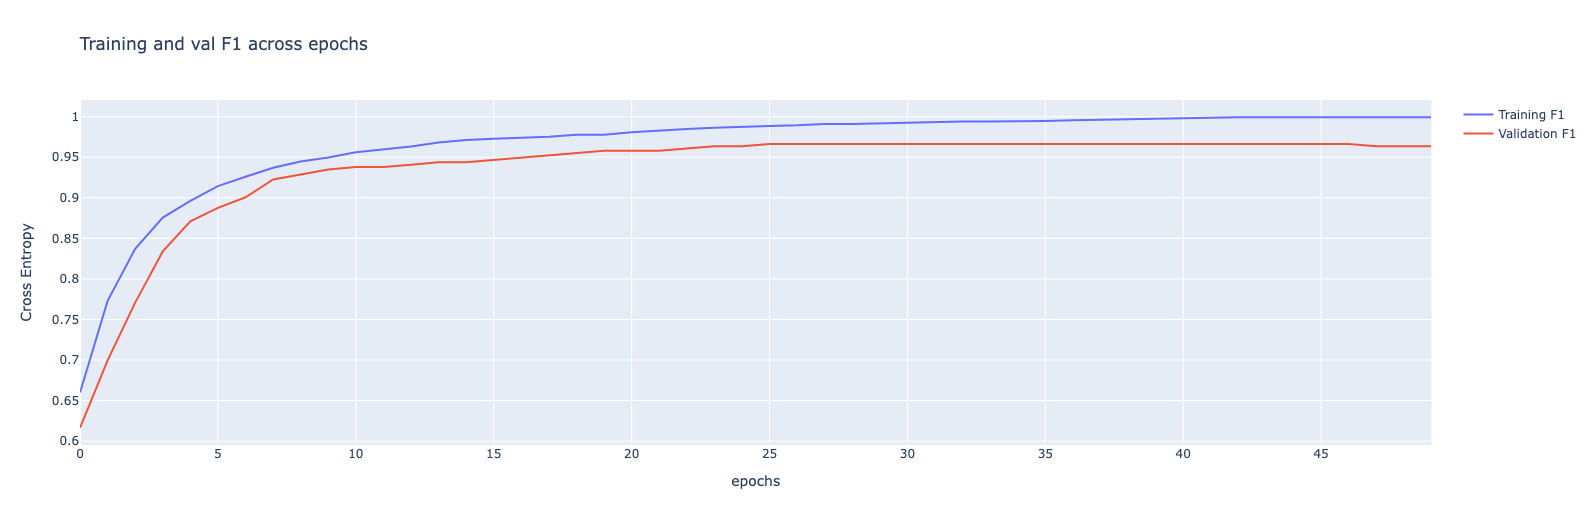